In [ ]:
# Install libraries
# https://docs.tweepy.org/en/stable/index.html
# https://pypi.org/project/deep-translator/
# https://github.com/bsolomon1124/demoji
# https://pypi.org/project/textblob/
# https://pypi.org/project/flair/

%pip install deep-translator
%pip install demoji
%pip install textblob 
%pip install flair

In [10]:
# Set-up notebook
import datetime
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
import demoji
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
import matplotlib.pyplot as plt

nltk.download('vader_lexicon')

flair_model = TextClassifier.load('en-sentiment')
def flair_prediction(x):
    sentence = Sentence(x)
    flair_model.predict(sentence)
    score = sentence.labels[0]
    if 'POSITIVE' in str(score):
        return 1
    elif 'NEGATIVE' in str(score):
        return -1
    else:
        return 0

keyword = input('Enter the keyword used in this search: ')

2022-11-05 20:45:42,759 loading file C:\Users\ellie\.flair\models\sentiment-en-mix-distillbert_4.pt


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ellie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# Import recent tweets
df = pd.read_csv('tweets/'+keyword+'.csv', on_bad_lines='skip',header=None, 
                    names=['return_order','user_id','created_at','edit_id','tweet_id','lang','text','keyword'])

# Remove duplicate entries
df = df.drop_duplicates(['tweet_id'])
df = df.sort_values(by=['created_at'], ascending=False)
df = df.reset_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         235 non-null    int64 
 1   return_order  235 non-null    int64 
 2   user_id       235 non-null    int64 
 3   created_at    235 non-null    object
 4   edit_id       235 non-null    object
 5   tweet_id      235 non-null    int64 
 6   lang          235 non-null    object
 7   text          235 non-null    object
 8   keyword       235 non-null    object
dtypes: int64(4), object(5)
memory usage: 16.6+ KB


In [6]:
# Translate Twitter data
i = 0 # iterator
text_translated = []

for row in df.iterrows():
    translated = GoogleTranslator(source='auto', target='en').translate(df.loc[i]['text'])
    translated = demoji.replace_with_desc(translated)
    text_translated.append(translated)
    i += 1

df['text_translated'] = text_translated  

In [7]:
# Process Twitter data
i = 0 # iterator
textblob_sentiment = []
textblob_subjectivity = []
nltk_sentiment = []
flair_sentiment = []

for row in df.iterrows():
    
    textblob = TextBlob(df.loc[i]['text_translated'])
    nltk = SentimentIntensityAnalyzer().polarity_scores(df.loc[i]['text_translated'])
    flair = flair_prediction(df.loc[i]['text_translated'])
    
    textblob_sentiment.append(textblob.sentiment.polarity)
    textblob_subjectivity.append(textblob.subjectivity)
    nltk_sentiment.append(nltk['compound'])
    flair_sentiment.append(flair)
   
    i += 1

df['textblob_sentiment'] = textblob_sentiment
df['textblob_subjectivity'] = textblob_subjectivity
df['nltk_sentiment'] = nltk_sentiment
df['flair_sentiment'] = flair_sentiment

In [8]:
# Calculate composite score + class
i = 0 # iterator
score = []
score_class =[]

for row in df.iterrows():

    total_sentiment = df.loc[i]['textblob_sentiment'] + df.loc[i]['nltk_sentiment']
    
    if total_sentiment == 0:
        sentiment
    else:
        sentiment = abs(total_sentiment / 2)
    
    sub_sentiment = sentiment + df.loc[i]['textblob_subjectivity']
    polar_sentiment = sub_sentiment * df.loc[i]['flair_sentiment']
    
    if abs(polar_sentiment) > 1:
        prefix = 'strong '
    else: 
        prefix = ''
        
    if polar_sentiment > 0.15:
        polarity = 'positive'
    elif polar_sentiment < -0.15:
        polarity = 'negative'
    else:
        polarity = 'neutral'
        
    polarity = prefix + polarity
    
    score.append(polar_sentiment)
    score_class.append(polarity)
    i += 1
    
df['polar_sentiment'] = score
df['score_class'] = score_class

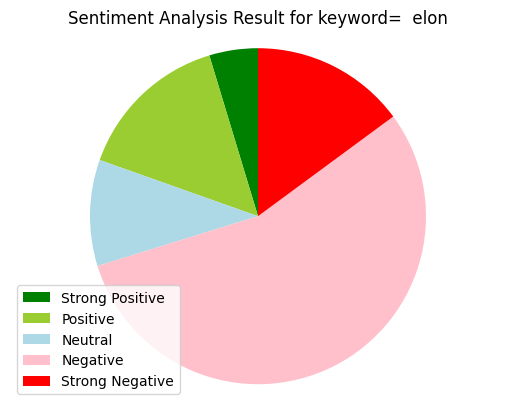

,index,return_order,user_id,created_at,edit_id,tweet_id,lang,text,keyword,text_translated,textblob_sentiment,textblob_subjectivity,nltk_sentiment,flair_sentiment,polar_sentiment,score_class
0,100,905,3868931718,2022-11-06 02:32:46+00:00,[1589083338886684672],1589083338886684672,en,RT @coin_apes: 🎉Project information🎉\nAPESCOIN...,elon,RT @coin_apes: :party popper:Project informati...,0.000000,0.000000,0.4019,-1,-0.200950,negative
1,103,902,9264162,2022-11-06 02:32:46+00:00,[1589083340476665858],1589083340476665858,en,RT @vogon: elon is giving people a masterclass...,elon,RT @vogon: elon is giving people a masterclass...,0.542857,0.642857,0.7579,1,1.293236,strong positive
2,105,900,1394527426378702850,2022-11-06 02:32:46+00:00,[1589083341265207296],1589083341265207296,en,@PopCrave Elon is disgusting,elon,@PopCrave Elon is disgusting,-1.000000,1.000000,-0.5267,-1,-1.763350,strong negative
3,104,901,555394813,2022-11-06 02:32:46+00:00,[1589083340673458176],1589083340673458176,en,RT @PalmerReport: Valerie Bertinelli has chang...,elon,RT @PalmerReport: Valerie Bertinelli has chang...,0.000000,0.000000,0.0000,-1,-0.763350,negative
4,99,906,999403656720990211,2022-11-06 02:32:46+00:00,[1589083338459205633],1589083338459205633,en,RT @WeirdDreamBooth: Elon Musk forcing childre...,elon,RT @WeirdDreamBooth: Elon Musk forcing childre...,0.000000,0.000000,0.0000,-1,-0.763350,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,98,98,1501976936742113280,2022-11-06 02:30:11+00:00,[1589082688396619776],1589082688396619776,en,@TheSGTJoker @DrOz The cluelessness is stark. ...,elon,@TheSGTJoker @DrOz The cluelessness is stark. ...,-0.088889,0.288889,0.0000,-1,-0.333333,negative
231,91,91,1539496866462609409,2022-11-06 02:30:11+00:00,[1589082691290681344],1589082691290681344,en,RT @crypteye_: @elonmusk Chad Elon ln https://...,elon,RT @crypteye_: @elonmusk Chad Elon ln https://...,0.000000,0.000000,0.0000,1,0.044444,neutral
232,90,90,1530404937762754562,2022-11-06 02:30:11+00:00,[1589082691307458561],1589082691307458561,en,RT @Politix_LIVE: BREAKING: ELON MUSK confirm...,elon,RT @Politix_LIVE: BREAKING: ELON MUSK confirm...,0.000000,0.100000,0.0000,-1,-0.144444,neutral
233,93,93,1290018339398381569,2022-11-06 02:30:11+00:00,[1589082690682490882],1589082690682490882,en,RT @GDoc2001: Kanye West: I can't believe how ...,elon,RT @GDoc2001: Kanye West: I can't believe how ...,0.416667,0.500000,-0.5411,-1,-0.562217,negative


In [11]:
#Create piechart
strong_positive = len(df[df['score_class'] == 'strong positive'])
positive = len(df[df['score_class'] == 'positive'])
neutral = len(df[df['score_class'] == 'neutral'])
negative = len(df[df['score_class'] == 'negative'])
strong_negative = len(df[df['score_class'] == 'strong negative'])

#labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
labels = ['Strong Positive', 'Positive','Neutral','Negative','Strong Negative']
sizes = [strong_positive, positive, neutral, negative, strong_negative]
colors = ['green','yellowgreen','lightblue','pink','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title('Sentiment Analysis Result for keyword=  '+keyword+'')
plt.axis('equal')
plt.show()

df